# RRT Path planning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Tree Class

In [2]:
class Tree:
    def __init__(self):
        self.vertices = []
        self.edges = []

    def add_vertex(self, point):
        self.vertices.append(point)

    def add_edge(self, point_idx):
        self.edges.append(point_idx)

## Environment Class

In [3]:
class Environment:
    def __init__(
        self,
        x_min,
        y_min,
        x_max,
        y_max
    ):
        self.x_min = x_min
        self.y_min = y_min
        self.x_max = x_max
        self.y_max = y_max
        self.obstacles = []

    def add_obstacle(self, obj):
        self.obstacles.extend(obj)

## RRT Class

In [4]:
class RRT:
    """
    RRT path planning
    """
    def __init__(
        self, 
        env,
        start, 
        goal,
        delta_distance=1,
        epsilon = 0.1,
        max_iter=1000, 
    ):
        self.env = env
        self.start = start
        self.goal  = goal
        self.delta_dis = delta_distance
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.T = Tree()

    def generate_path(self):
        path = None
        self.T.add_vertex(self.start)
        for k in range(self.max_iter):
            rand_point = self.random_state()
            near_point, near_idx = self.nearest_neighbor(rand_point, self.T)
            new_point  = self.new_state(near_point, rand_point)

            if self.collision_free(near_point, new_point):
                self.T.add_vertex(new_point)
                new_idx = len(self.T.vertices) - 1
                self.T.add_edge([near_idx, new_idx])

                if self.reach_to_goal(new_point):
                    print("reached to the goal")
                    path = self.find_path(self.T)
                    break
        return path

    def random_state(self):
        if np.random.random() > self.epsilon:
            point = np.array([np.random.uniform(self.env.x_min, self.env.x_max),
                              np.random.uniform(self.env.y_min, self.env.y_max)]) 
        else:
            point = self.goal
        return point

    def nearest_neighbor(self, random_point, tree):
        distances = [self.distance(random_point - point) 
                     for point in tree.vertices]
        nearest_idx = np.argmin(distances)
        nearest_point = tree.vertices[nearest_idx]
        return nearest_point, nearest_idx

    def distance(self, vector):
        return np.linalg.norm(vector)

    def new_state(self, nearest_point, random_point):
        vector = random_point - nearest_point
        dist = self.distance(vector)
        step = min(self.delta_dis, dist)
        unit_vector = vector / dist
        new_point = nearest_point + unit_vector * step

        return new_point

    # TODO
    # use fcl lib
    def collision_free(self, pointA, pointB):
        for (obs_x, obs_y, obs_r) in self.env.obstacles:
            if self.is_inside_circle(obs_x, obs_y, obs_r, pointB):
                return False
            if self.is_intersect_circle(obs_x, obs_y, obs_r, pointA, pointB):
                return False
        return True

    def is_inside_circle(self, x, y, r, point):
        obs_point = np.array([x, y])
        distances = self.distance(point - obs_point)
        if distances <= r + self.delta_dis:
            return True
        return False

    def is_intersect_circle(self, x, y, r, pointA, pointB):
        vectorAB = pointB - pointA

        distanceAB = self.distance(vectorAB)
        if distanceAB == 0:
            return False

        pointC = np.array([x, y])
        vectorAC = pointC - pointA
        proj = np.dot(vectorAC, vectorAB) / distanceAB
        proj = np.clip(proj, 0, 1)

        pointD = pointA + proj * vectorAB
        distancCD = self.distance(pointD - pointC)
        
        if distancCD <= r + self.delta_dis:
            return True
        return False

    def reach_to_goal(self, point):
        dist = self.distance(point-self.goal)
        if dist <= 0.5:
            return True
        return False

    def find_path(self, tree):
        path = [self.goal]
        goal_idx = tree.edges[-1][1]
 
        while goal_idx != 0:
            path.append(tree.vertices[goal_idx])
            parent_idx = tree.edges[goal_idx-1][0]
            goal_idx = parent_idx
        path.append(self.start)

        return path[::-1]

    def get_rrt_tree(self):
        vertices = []
        for edge in self.T.edges:
            from_node = self.T.vertices[edge[0]]
            goal_node = self.T.vertices[edge[1]]
            vertices.append((from_node, goal_node))
        return vertices

In [5]:
def plot_circle(x, y, size, color="-b"):  # pragma: no cover
    deg = list(range(0, 360, 5))
    deg.append(0)
    xl = [x + size * np.cos(np.deg2rad(d)) for d in deg]
    yl = [y + size * np.sin(np.deg2rad(d)) for d in deg]
    plt.plot(xl, yl, color)

reached to the goal


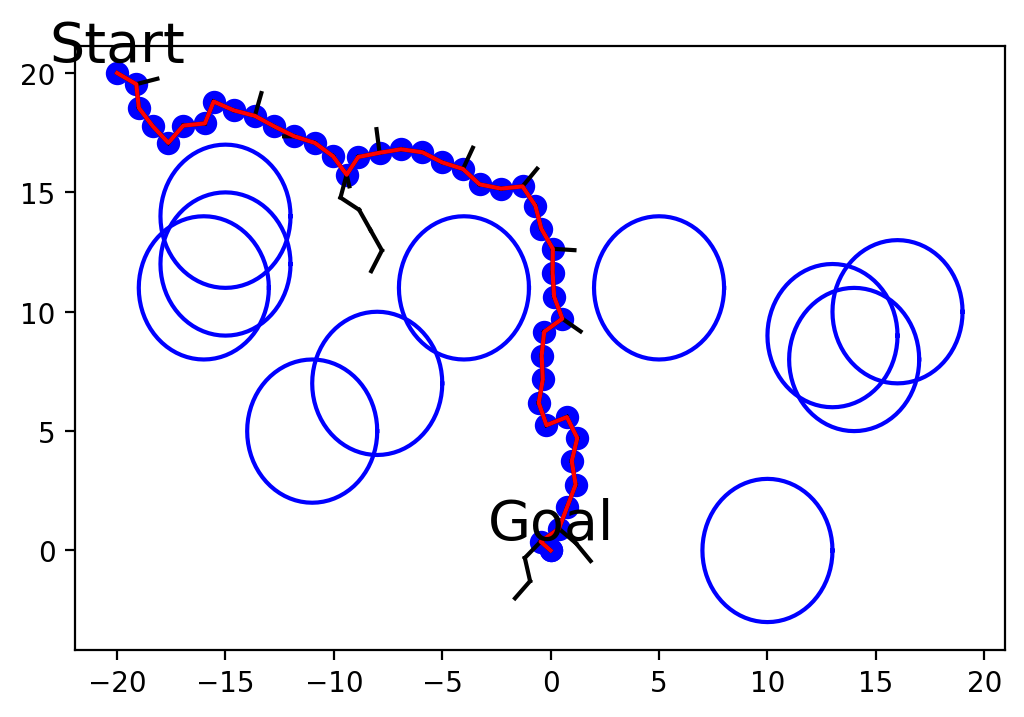

In [6]:
env = Environment(x_min=-20, y_min=-20, x_max=20, y_max=20)
plt.rcParams['figure.dpi'] = 200
circles = []
x, y, radius = (0, -15, 3)
for i in range(10):
    x = np.random.randint(-18, 18)
    y = np.random.randint(5, 15)
    circles.append((x, y, radius))
circles.append((10, 0, 3))

env.add_obstacle(circles)

start_point = np.array([-20, 20])
goal_point  = np.array([0, 0])

planner = RRT(env, start=start_point, goal=goal_point, delta_distance=1, epsilon=0.2, max_iter=1000)

path = planner.generate_path()
tree = planner.get_rrt_tree()

for circle in circles:
    plot_circle(circle[0], circle[1], circle[2])

for virtex in tree:
    plt.plot([x for (x, y) in virtex],[y for (x, y) in virtex], 'k')

if path is None:
    print("cannot create path")
else:
    plt.scatter([x for (x, y) in path], [y for (x, y) in path], s=55, c = 'b')
    plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
    plt.text(path[0][0], path[0][1], 'Start', verticalalignment='bottom', horizontalalignment='center', size="20")
    plt.text(path[-1][0], path[-1][1], 'Goal', verticalalignment='bottom', horizontalalignment='center', size="20")
plt.show()